In [35]:
import numpy as np
import scvi
import torch.nn
from scvi.data import AnnDataManager
from scvi.data.fields import CategoricalObsField, LayerField
from scvi.dataloaders import AnnDataLoader
import torch
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
import os
import sys
plt.style.use('default')
sys.path.append("../src")  # 将 src 目录添加到 Python 路径
import re
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Original

In [5]:
adata = scvi.data.synthetic_iid()
adata.layers['count'] = adata.X.copy()

In [6]:
anndata_fields = [
    LayerField(registry_key="x", layer=None, is_count_data=True),
    LayerField(registry_key="count", layer="count", is_count_data=True),
    CategoricalObsField(registry_key="batch", attr_key="batch"),
]
adata_manager = AnnDataManager(fields=anndata_fields)
adata_manager.register_fields(adata)
print(adata_manager.registry.keys())

dict_keys(['scvi_version', 'model_name', 'setup_args', 'field_registries', '_scvi_uuid'])


In [7]:
adata_manager.view_registry()

Anndata setup with scvi-tools version 1.2.0.

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_batch      │   2   │
│     n_count      │  100  │
│       n_x        │  100  │
└──────────────────┴───────┘

               Data Registry               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃   scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    batch     │ adata.obs['_scvi_batch'] │
│    count     │  adata.layers['count']   │
│      x       │         adata.X          │
└──────────────┴──────────────────────────┘

                  batch State Registry                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃  Source Location   ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch'] │  batch_0   │          0          │
│                    │  batch_1   │          1          │
└────────────────────┴────────────┴─────────────────────┘

### My Model

In [46]:
from model import BulkVAE
from scvi.model import CondSCVI

In [44]:
adata = sc.read_h5ad('/home/DingchengYi/BulkPheno/data/Simulation/sim1.h5ad')
adata

AnnData object with n_obs × n_vars = 2000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    obsm: 'X_pca', 'X_umap'

In [47]:
CondSCVI.setup_anndata(adata, 'Group')
adata

AnnData object with n_obs × n_vars = 2000 × 500
    obs: 'Cell', 'Group', 'ExpLibSize', 'sizeFactor', '_scvi_labels'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_umap'

In [48]:
new_model = CondSCVI(adata, n_latent=32)
new_model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/DingchengYi/miniforge3/envs/pyg/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training:   0%|          | 0/300 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [49]:
SCVI_LATENT_KEY = "X_Cond_scVI"

adata.obsm[SCVI_LATENT_KEY] = new_model.get_latent_representation()

In [50]:

sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.leiden(adata)
sc.tl.umap(adata)

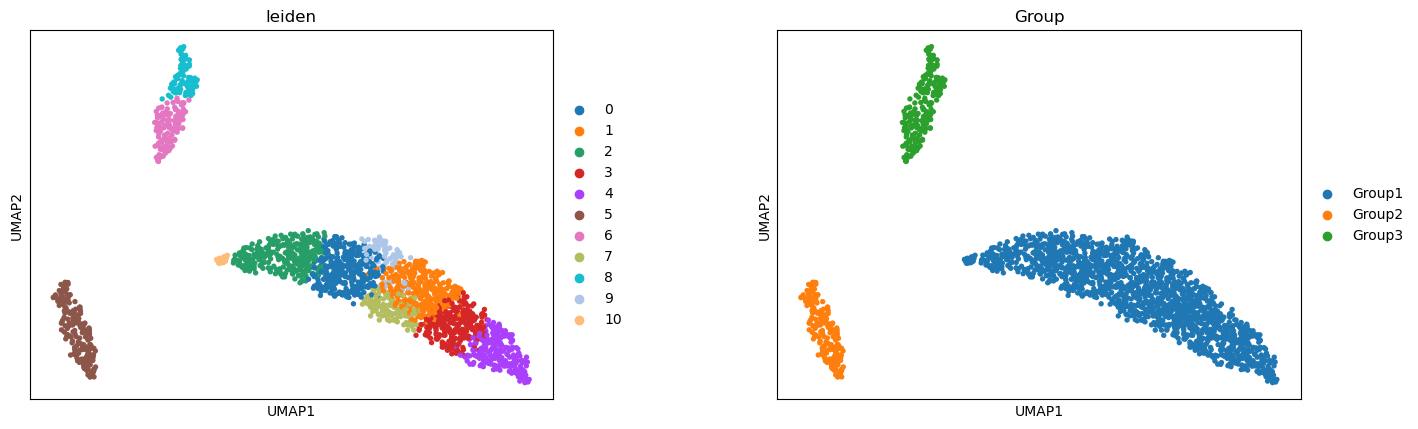

In [51]:
sc.pl.umap(adata, color=["leiden", 'Group'], wspace=0.3)